# Clustering

## 1. Introduction

Clustering involves organising objects in a space according to their similarity to one another. Clustering is a form of **unsupervised learning**, because we don't need any labels, and instead organize objects according to their features. For example, if we have objects of different sizes and colours, we can cluster them according size or colour, or both.

Clustering is particularly useful when we have tasks like compression. For example, say that we have an image with 256 colours, and we want to downsample it to only 16. One way of doing this would be to cluster the data according to colour, and to find the 16 most important colours. If you did this, you could discard all of the remaining colours, and replace them with whichever of the 16 colours they are closest to. For example:

![Title](img/toucan.png)

In general, clustering lets us both find patterns in data, and reduce its dimensionality where it's beneficial to do so. Finally, clustering using latent spaces is becoming more and more important in the cutting edge of AI, where it's used to autonomously learn lower-dimensional state representations for control algorithms. Rather than dealing with high dimensional representations like pixels, we can compress the data to help our agents learn using a more distilled representation. This isn't just useful in more advanced areas like RL; it's also useful when doing basic data analysis and modelling.

In this notebook, we cover three basic techniques: K-Means Clustering, Gaussian Mixture Models, and Deep Autoencoders. These are intended as stepping stones to illustrate the basic techniques, and should provide a good foundation for understanding more advanced methods such as Variational Autoencoders, Mixture Density Networks, and Generative Adversarial Networks.

## 2. K-Means Clustering

K-Means Clustering is a straightforward way of automatically clustering complex datasets. The algorithm works as follows:

1. Initialize a set of $k$ observations randomly;
2. For each observation, assign the closest datapoints to it as a group;
3. For each group, calculate the centroid;
4. Update the position of each observation to move to the centroid of its group;
5. Repeat steps 2 to 4 until convergence.

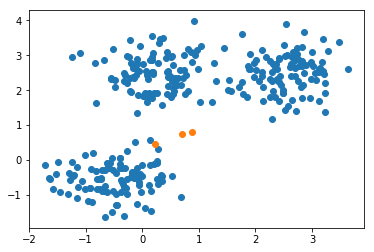

In [3]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import random
    
mux_1, stdx_1 = 2.5, 0.5
muy_1, stdy_1 = 2.5, 0.5

mux_2, stdx_2 = -0.5, 0.5
muy_2, stdy_2 = -0.5, 0.5

mux_3, stdx_3 = 0.25, 0.5
muy_3, stdy_3 = 2.5, 0.5

samples = 100

x_1 = np.array([random.gauss(mux_1, stdx_1) for _ in range(samples)])
y_1 = np.array([random.gauss(muy_1, stdy_1) for _ in range(samples)])

x_2 = np.array([random.gauss(mux_2, stdx_2) for _ in range(samples)])
y_2 = np.array([random.gauss(muy_2, stdy_2) for _ in range(samples)])

x_3 = np.array([random.gauss(mux_3, stdx_3) for _ in range(samples)])
y_3 = np.array([random.gauss(muy_3, stdy_3) for _ in range(samples)])

x = np.hstack([x_1, x_2, x_3])
y = np.hstack([y_1, y_2, y_3])

coords = np.vstack([x, y]).T

k = 3
obs = np.vstack([np.random.rand(2,) for _ in range(k)])

ax = plt.axes()
ax.scatter(x, y)
ax.scatter(obs[:,0], obs[:,1])
plt.show()

Below is a fairly naive implementation of a k-means clustering algorithm:

Initial point locations: 
[[ 0.88537953  0.8014463 ]
 [ 0.70489851  0.74238477]
 [ 0.23181624  0.45355551]]

Final point locations: 
[[ 2.52658272  2.49146181]
 [ 0.2156173   2.50764906]
 [-0.49567805 -0.53797218]]


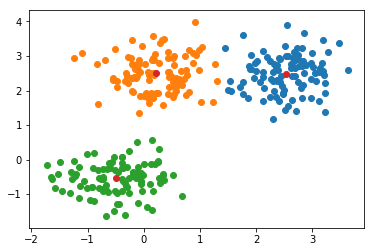

In [4]:
print("Initial point locations: ")
print(obs)

for _ in range(5):    
    # association step
    groups = []
    for i, o in enumerate(obs):
        collective = []
        for j, pt in enumerate(coords):
            closest = 100.
            closest_idx = 0
            for k, p in enumerate(obs):
                err = (p-pt)
                dist = np.linalg.norm(err)
                if dist < closest:
                    closest_idx = k
                    closest = dist
            if closest_idx == i:
                collective.append(pt)
        groups.append(collective)
    
    # update step
    centroids = []
    for i, col in enumerate(groups):
        col = np.vstack(col)
        centroid = np.sum(col, axis=0)/col.shape[0]
        obs[i] = centroid

print()
print("Final point locations: ")
print(obs)
        
ax = plt.axes()
for g in groups:
    xy = np.vstack(g)
    ax.scatter(xy[:,0], xy[:,1])
ax.scatter(obs[:,0], obs[:,1])
plt.show()

As we can see, we've managed to cluster the data fairly effectively. In certain cases, it may be difficult to determine exactly how many centroids there should be. Furthermore, it's possible for the algorithm to get stuck in a local minima (i.e. for more complex datasets, multiple points may reach the same centroid). For this reason, it is standard practice to repeat the algorithm with multiple initializations of $k$, and to pick the solution with the lowest cost.

A further problem with k-means is that it assigns hard centroids to the data, which can present issues if, for example, clusters overlap. To get around this, we can use a more advanced clustering algorithm called a Gaussian Mixture Model.

## 3. Gaussian Mixture Models

Another useful clustering algorithm is known as the mixture model. This is actually a soft version of the k-means algorithm. The idea is relatively straightforward: in some situations, we may have data that is multi-modal (i.e. a dataset consisting of multiple clusters as above). An effective way to capture such a distribution is to use a mixture of Gaussians. Each Gaussian is unimodal, but by having a weighted mixture of each, we can cluster very complex datasets.

Gaussian Mixture Models are trained using the Expectation Maximization algorithm, which has two phases:
1. The expectation step: for each datapoint, estimate the probability that the Gaussian generated it; and,
2. The maximization step: modify the parameters to maximize the likelihood of the data.

We implement a very basic GMM in the code below:

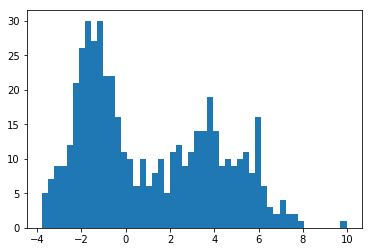

In [5]:
mu_1 = -1.5
sigma_1 = 1

mu_2 = 3.5
sigma_2 = 2

samples = 250

x_1 = np.array([random.gauss(mu_1, sigma_1) for _ in range(samples)])
x_2 = np.array([random.gauss(mu_2, sigma_2) for _ in range(samples)])
xs = np.hstack([x_1, x_2])

ax = plt.axes()
ax.hist(xs, bins=50)
plt.show()

Next, the algorithm:

In [8]:
from math import pi, sqrt, exp

gaussian_pdf = lambda x, mu, sigma : (1/np.sqrt(2*pi*sigma**2))*np.exp(-(x-mu)**2/(2*(sigma**2)))

k = 2
mus = np.array([mu_1+np.random.randn(), mu_2+np.random.randn()])
sigmas = np.hstack([np.random.rand() for _ in range(k)])
mix = np.array([1/k for _ in range(k)])

print("Initial mus: ", mus)
print("Initial sigmas: ", sigmas)
print("Initial mix: ", mix)
print()

xs_array = np.vstack([xs, xs]).T
alpha = 5e-3

for it in range(50):
    # expectation step
    mix_array = np.vstack([mix for _ in range(xs.shape[0])]).T
    mus_array = np.vstack([mus for _ in range(xs.shape[0])]).T
    sigmas_array = np.vstack([sigmas for _ in range(xs.shape[0])]).T
    weights = []
    for i, pt in enumerate(xs):
        weight = []
        for j in range(k):
            prob = mix[j]*gaussian_pdf(pt, mus[j], sigmas[j])
            weight.append(prob)
        weights.append(weight)
    
    weight_array = np.array(weights)
    denominators = np.sum(weight_array, axis=1)
    rs = []
    for i, pt in enumerate(xs):
        r = weight_array[i,:]/denominators[i]
        rs.append(r)
    log_prob = np.sum(np.log(denominators), axis=0)
    rs = np.array(rs)
    if it % 10 == 0:
        print("Iteration: {}, Log-probability: {:.3f}".format(it, log_prob))
    
    # maximization step
    mix = (1-alpha)*mix+alpha*np.mean(rs, axis=0)
    mus = (1-alpha)*mus+alpha*np.sum(rs*xs_array,axis=0)/np.sum(rs, axis=0)
    cum_sum = 0
    for i, pt in enumerate(xs):
        err = pt-mus
        cum_sum += rs[i,:]*(err**2)
    sigmas = (1-alpha)*sigmas+alpha*cum_sum/np.sum(rs, axis=0)

print()
print("Final mus: ", mus)
print("Final sigma: ", sigmas)
print("Final mix: ", mix)

Initial mus:  [-1.85232901  5.08263132]
Initial sigmas:  [ 0.8028375   0.49145211]
Initial mix:  [ 0.5  0.5]

Iteration: 0, Log-probability: -2141.656
Iteration: 10, Log-probability: -1813.177
Iteration: 20, Log-probability: -1616.308
Iteration: 30, Log-probability: -1490.703
Iteration: 40, Log-probability: -1406.752

Final mus:  [-1.65513376  4.95459868]
Final sigma:  [ 1.21140831  0.86885213]
Final mix:  [ 0.52874763  0.47125237]


As we can see, the log-likelihood is slowly maximized. We check the performance of our model below:

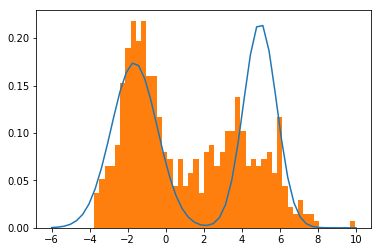

In [9]:
pred = lambda x, pi, mu, sigma : np.sum(pi * gaussian_pdf(x, mu, sigma))

x_test = np.linspace(-6,10,50)
preds = []
for x in x_test:
    tiled = np.array([x, x])
    output = pred(tiled, mix, mus, sigmas)
    preds.append(output)

ax = plt.axes()
ax.plot(x_test, np.array(preds))
ax.hist(xs, bins=50, density=True)
plt.show()

In this case, we managed to get a nice fit, but it sometimes takes a few tries to get something that converges to a good result. We had to use a few small additions to improve the stability and convergence of the algorithm:

1. We initialized the means close to where the true means were. We can actually use k-means for this initial step.
2. We used a small update step for the mixing coefficients, means, and sigmas. This is standard practice in cases where our function can blow-up. In this case, we can feasibly divide by zero, so we make small changes to our initial guesses to mitigate this.

This example really only works for the 1D case, and would need to be modified for the 2D case. To do so, you would need to modify the Gaussian pdf to be a multivariate distribution (with a covariance matrix), and you would need to update the learning rule for $\Sigma$.

The advantage of a Gaussian Mixture Model is that -- now that we have a clustering of our data -- we can generate new examples by sampling from the PDF (as their name implies, models that can generate new examples are called **generative models**). This is a relatively straightforward process: 

1. First, we categorically sample from the mixing distribution (e.g. if we have two mixing values of $[0.1, 0.9]$, we choose index 0 10% of the time, and index 1 90% of the time).
2. Once we have the index, we randomly sample from the corresponding Gaussian function.

This is shown in code below:

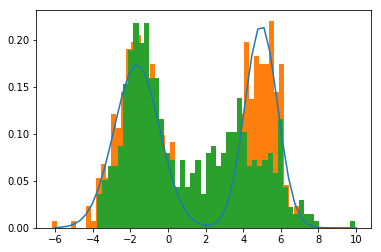

In [10]:
def sample_gmm(mixes, mus, sigmas):
    idx = np.argmax(np.random.multinomial(1, mixes))
    return np.random.normal(mus[idx], sigmas[idx])

generated_data = []
for i in range(500):
    generated_data.append(sample_gmm(mix, mus, sigmas))

ax = plt.axes()
ax.plot(x_test, np.array(preds))
ax.hist(generated_data, bins=50, density=True)
ax.hist(xs, bins=50, density=True)
plt.show()

As the figure shows, we managed to get a good approximation of the original distribution. 

In the next section, we'll look at how we can do clustering with deep neural networks.

## 4. Clustering With Neural Networks

We can automatically cluster with neural networks using an architecture known as an autoencoder. Autoencoders are a form of unsupervised learning, meaning we don't need labels to train the network. Unlike a standard supervised learning task in which the network is trained to maximize $\frac{1}{2N}\sum_{i=i}^{N}-(y-y^{*})^{2}$, autoencoders use the loss function:

\begin{equation}
\mathcal{L} = \frac{1}{2NM}\sum_{i=i}^{M}\sum_{j=1}^{N}-(X_{ij}-X_{ij}^{*})^{2}
\end{equation}

Which is to say that the network learns to reconstruct its input. This is done through the use of a split architecture:

![title](img/autoencoder.png)

The network consists of two parts: and encoder and a decoder. The encoder takes the input, and outputs a compressed representation $z$; the decoder takes $z$ as input and outputs an estimate of the input $X$, such that $X \approx X^{*}$. The trick is that the dimensionality of $z$ is much lower than the dimensionality of $X$, meaning that the network has to discard non-essential information. The result is that the network automatically learns a clustering of inputs in the latent space $z$.

We implement this in the code below:

In [50]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

# first, grab our data
batch_size = 128
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# next, write our autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 2))
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

I've given our network a 2D latent space, so that we can plot it easily once the network is trained. In practice, the dimensionality of the latent space can be whatever the engineer chooses; it's a hyperparameter that is tuned to best suit the task at hand.

To train it, we use the following loop:

In [51]:
learning_rate = 1e-3
model = Autoencoder()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

log_freq = 1
iters = 10
for epoch in range(iters):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        output = model(img)
        loss = loss_func(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % log_freq == 0:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, iters, loss.item()))
        pic = to_img(output.cpu().data)

epoch [1/10], loss:0.2080


This is similar to our previous loops, except that now we're minimizing the loss between the ouput of the network, and our image input, rather than the output and the labels.

We can visualize the clustering the latent space by feeding inputs into the encoder, and then plotting the latent space:

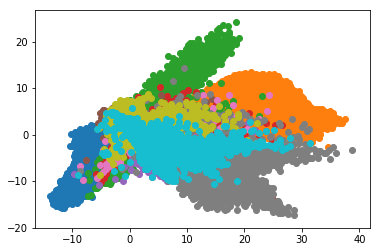

In [62]:
encodings = []
labels = []
for data in dataloader:
    with torch.no_grad():
        img, label = data
        img = img.view(img.size(0), -1)
        encoded = model.encoder(img)
        encodings.append(encoded.numpy())
        labels.append(label.numpy())

ax = plt.axes()
a, b, c, d, e, f, g, h, i, j = [], [], [], [], [], [], [], [], [], [] 
for o, (enc, label) in enumerate(zip(encodings, labels)):
    for p in range(label.shape[0]):
        if label[p] == 0:
            a.append(enc[p])
        if label[p] == 1:
            b.append(enc[p])
        if label[p] == 2:
            c.append(enc[p])
        if label[p] == 3:
            d.append(enc[p])
        if label[p] == 4:
            e.append(enc[p])
        if label[p] == 5:
            f.append(enc[p])
        if label[p] == 6:
            g.append(enc[p])
        if label[p] == 7:
            h.append(enc[p])
        if label[p] == 8:
            i.append(enc[p])
        if label[p] == 9:
            j.append(enc[p])

organized = [a, b, c, d, e, f, g, h, i, j]
for d in organized:
    xys = np.vstack(d)
    ax.scatter(xys[:,0], xys[:,1])
plt.show()

As we can see, the network has learned to cluster the individual numbers without us having to provide any additional inputs or labels. Unlike the previous clustering algorithms, the dimensionality in the latent space of the autoencoder has unknown units. It's just an amorphous $z$. However, this type of representation can be very useful for learning more intelligent agents, since it creates a more information-dense space to work with. This is particularly useful when working with very high-dimensional, information-poor representations such as image pixels.

More modern autoencoder designs typically enforce a constraint on the latent variable $z$, by compressing it onto a probability distribution $z \sim \mathcal{N}\left(0, I\right)$. The advantage of this is that it lets us sample from the distribution, and generate new examples (i.e. it is a generative model). This technology is what underlies some of the major advances in deep learning over the past two years.

## 5. Summary
In this notebook, we've covered several unsupervised learning algorithms that are designed to cluster data. We've covered not only traditional methods such as k-means and the Gaussian Mixture Model -- we've also included a brief look into using deep neural networks to perform clustering in a latent space. 

You might ask what some of these algorithms are useful for? Clustering has found applications in compression, where it can be used to downsample images and video. Autoencoders are being heavily researched for their ability to make learning easier, by taking complex state information, and compressing it into a form that is more easily used by a neural net. This has application in reinforcement learning, and is the backbone of cutting edge generative models such as VAEs and GANs.